# Active transfer learning
pool is a list of data that it hasn't been labled yet.
labeled_data is a list of data that has been labeled

## setup

In [ ]:
import tensorflow as tf
import torch
import os
import pickle
import pandas as pd
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
% matplotlib inline
import json
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
!pip install modAL


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


## Importing data :
getting a test and train data set

In [ ]:
!git clone "https://github.com/parsafarinnia/sentiment_new_approach"

Cloning into 'sentiment_new_approach'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 47 (delta 12), reused 34 (delta 4), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [ ]:
all_topics = pickle.load( open( "/content/sentiment_new_approach/all_topics.p", "rb" ) )
data=pd.DataFrame.from_dict(all_topics[0]).T
data['topic']=0
for i in range(1,9):
  topic = pd.DataFrame.from_dict(all_topics[i]).T
  if i == 3: print('hi')
  topic['topic'] = i
  data = pd.concat([data,topic],axis=0)
map = {"rumours":1,"non-rumours":0}
data=data.replace({'tag':map})
data  

hi


,text,tag,topic
553529101659566080,BREAKING: Armed man takes hostage in kosher gr...,1,0
553587735613952001,"#CharlieHebdo killers dead, confirmed by genda...",1,0
552816932643405824,"Top French cartoonists Charb, Cabu, Wolinski, ...",1,0
553515399438811136,Police have surrounded the area where the #Cha...,1,0
552808620187217920,PHOTO: Armed gunmen face police officers near ...,1,0
...,...,...,...
544463778780557312,'I'll ride with you' http://t.co/llZnuCAzg5 Au...,0,8
544305018439204864,Canada's thoughts and prayers are with our Aus...,0,8
544415816851021824,Every non-muslim in the world must watch this ...,0,8
544495066258362368,Suspect in Sydney cafe siege identified as Man...,0,8


In [ ]:
data.groupby(['topic']).count()

,text,tag
topic,,
0,2079,2079
1,14,14
2,1143,1143
3,469,469
4,138,138
5,890,890
6,233,233
7,238,238
8,1221,1221


## Word embedings

### selecting test train eval set

#### 0's topic test and rest train

In [ ]:
test_df = data[data['topic']==0]
train_df = data[data['topic']!=0]
train_df.head()

,text,tag,topic
521369179392581632,Micheal Essien denying the Ebola rumours like ...,1,1
521367917322338304,No truth in internet rumours that I have contr...,1,1
522286703848218624,Essien and his lawyers are considering to file...,1,1
521375609206083584,Good news: The rumours that Michael Essien has...,1,1
521358118597689344,Milan have stated that the reports about Essie...,1,1


In [ ]:
data2=data.reset_index()
start_test=data2[data2['topic']==0].iloc[0]
# end_test=data2[data2['topic']==0].iloc[-1]
# start_train =data2[data2['topic']==1].iloc[0]
# end_train = start_test=data2[data2['topic']==8].iloc[-1]
def pd_iter_func(df,topic):
    for row in df.itertuples():
        # Define your criteria here
        if row.topic ==topic:
            return row
start_test=pd_iter_func(data2,0).Index
end_test = pd_iter_func(data2,1).Index-1
train_start = pd_iter_func(data2,1).Index
train_end = len(data2)
print(train_start,',',train_end)


2079 , 6425


In [ ]:
train_sentences = train_df.text.values
test_sentences = test_df.text.values
train_labels = train_df.tag.values
test_labels = test_df.tag.values
len(train_labels)

4346

### Representation

#### BERT

In [ ]:
sentence_feature=np.load('/content/sentiment_new_approach/vectorization/normal_bert.npy')

In [ ]:
sentence_feature=np.load('/content/sentiment_new_approach/vectorization/tweet_bert.npy')

In [ ]:
!pip install emoji


     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=8947b74ef665759b948f1059f9ca08064283b9e65be13ebc715442b108bf290c
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [ ]:
from transformers import AutoModel, AutoTokenizer 
# Load BERT TWEET tokenizer and model
bert_tweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer_tweet = AutoTokenizer.from_pretrained("vinai/bertweet-base",normalization=True)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def tokenizer_func(tokenizer_kind,sentences,labels):
  '''
  inputs:
    tokenizer_kind: is the the tokenizer of choice (normal bert, tweet bert)  
    sentences: train , dev, test
  outputs:
  torchs of 
    ids
    attention_mask
    labels
  '''
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer_kind.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 128,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation=True,
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks ,labels
  # Print sentence 0, now as a list of IDs.


In [ ]:
sentences = data.text.values
train_labels = data.tag.values
input_ids,attention_masks,labels=tokenizer_func(tokenizer_tweet,sentences,train_labels)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
batch_size=128
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
bert_tweet.cuda()
bert_tweet.eval()
# Tracking variables 
sentence_feature=[]
t1 = time.time()
for batch in prediction_dataloader:
  t0 = time.time()  
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = bert_tweet(b_input_ids, attention_mask=b_input_mask)
      
  sentence_features_slice = outputs[0][:,0,:].cpu().numpy()  
  # Store predictions and true labels
  sentence_feature.append(sentence_features_slice)
  elapsed = format_time(time.time() - t0)
  print("time elapse:",elapsed)
print("full time",format_time(time.time()-t1))
sentence_feature = np.concatenate(sentence_feature, axis=0)
print(sentence_feature.shape)

time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 0:00:01
time elapse: 

In [ ]:

with open('tweet_bert.npy', 'wb') as f:
    np.save(f, sentence_feature)

#### Glove word embeding

##### preprocessing

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords
import re
import os

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Change "@name" to "Username"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    - change urls to "Link"
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Change "@name" to "Username
    s = re.sub(r'(@.*?)[\s]', 'username', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    # change urls to "Link"
    s = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'link',s)
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import numpy as np
sentences = np.array([text_preprocessing(text) for text in data.text.values  ])



#####Glove



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/glove.twitter.27B.zip"

Archive:  /content/gdrive/My Drive/glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel
glove = loadGloveModel('glove.twitter.27B.200d.txt')

Loading Glove Model
1193514  words loaded!


In [ ]:
data_train = np.zeros(shape=(len(sentences),200),dtype=np.float)

for i in range(len(sentences)):
  tweet = sentences[i]
  tweet = tweet.split(' ')
  glove_word_count = 1
  for word in tweet:
    if word.lower() in glove:
      glove_word_count +=1
      data_train[i,:]+= glove[word]
  data_train[i,:]=data_train[i,:]/(glove_word_count)
features=data_train
#representation Glove

In [ ]:
sentence_feature=features

## ACTIVE LEARNING LOOP

### POOL and Labeled data and initial model defenition

In [ ]:

data_test = sentence_feature [start_test:end_test+1]
test_labels = test_labels
data_train = sentence_feature[train_start:train_end+1]
train_labels = train_labels
len(data_train)
BATCH_SIZE = 50

In [ ]:
from sklearn.model_selection import train_test_split
test_pool_split = 0.5
X_pool, X_train, y_pool, y_train = train_test_split(data_test, test_labels, test_size=20)
# X_pool, X_test, y_pool, y_test = train_test_split(X_pool, y_pool, test_size=test_pool_split)

In [ ]:
pip install modAl

### Models


#### ada boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()

#### MLP


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
def create_keras_model():
  model = Sequential()
  model.add(keras.Input(shape=(768,),name="source"))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
clf = KerasClassifier(create_keras_model)

In [ ]:
from modAL.models import ActiveLearner
from modAL.batch import uncertainty_batch_sampling
from functools import partial

y_train = keras.utils.to_categorical(y_train, 2)
y_pool = keras.utils.to_categorical(y_pool, 2)
# initialize ActiveLearner

#### SVM

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import svm
clf = svm.SVC(probability=True)


In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X, y)
clf.predict([0,0])

ValueError: ignored

In [ ]:
from sklearn import svm
def svm_model(data_train,Y_train):
  clf = svm.SVC(probabilty=True)
  clf=clf.fit(data_train, Y_train)
  return clf


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(max_depth=1000, random_state=0)


#### Naive Bayes


### running loop

In [ ]:
X_pool.shape

(2074, 768)

In [ ]:
def save_reesult(h,dest_add):
  with open(dest_add, 'wb') as f:
    np.save(f, h)

In [ ]:
from sklearn.metrics import f1_score
import random
def run_multy_0(BATCH_SIZE,data_test, test_labels  ,num_of_run,clf,strategy,train_size,is_random):
  test_pool_split=0.5
  preset_batch = partial(strategy, n_instances=BATCH_SIZE)
  test_labels = keras.utils.to_categorical(test_labels, 2)
  X_pool_0, X_test_0, y_pool_0, y_test_0 = train_test_split(data_test, test_labels, test_size=train_size,shuffle=True)
  X_pool_0, X_test_0, y_pool_0, y_test_0 = train_test_split(X_pool_0,y_pool_0, test_size=test_pool_split,shuffle=True)
  N_QUERIES = int(len(X_pool_0)/BATCH_SIZE)
  print(num_of_run,N_QUERIES)
  pref_hist_multy_accuracy=np.zeros((num_of_run,N_QUERIES))
  pref_hist_multy_f1=np.zeros((num_of_run,N_QUERIES))
  for i in range(num_of_run):
    X_pool, X_train, y_pool, y_train = train_test_split(data_test, test_labels, test_size=train_size,shuffle=True)
    X_pool, X_test, y_pool, y_test = train_test_split(X_pool,y_pool, test_size=test_pool_split,shuffle=True)
    print('shapeè y',y_train.shape)
    print('shapeè x',X_train.shape)
    clf = KerasClassifier(clf)
    learner = ActiveLearner(
    estimator=clf,
    query_strategy=preset_batch,
    X_training=X_train, y_training=y_train)
    t1 = time.time()
    print('8888888888888888888888888888888888888888')
    print(y_pool[0],y_pool[1],y_pool[2])
    print('shapeè',y_pool.shape)
    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      t2 = time.time()
      print('x pool length',len(X_pool))
      print('y pool length',len(y_pool))
      print(i,'th run and query number',index)
      query_index, query_instance = learner.query(X_pool)
      print('num if query',len(query_index))
      if is_random:
        index_list = range(len(X_pool))
        query_index = random.sample(index_list,BATCH_SIZE)
      # print(query_index,np.shape(X_pool),np.shape(y_pool))
      # Teach our ActiveLearner model the record it has requested.
      # X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1,)
      print('first',y_pool.shape)
      X, y = X_pool[query_index], y_pool[query_index]
      print(len(X))
      print(X.shape)
      print(y.shape)
      print(y[:5])
      for j in range(1):
        learner.teach(X=X, y=y)
      # Remove the queried instance from the unlabeled pool.
      X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index,axis=0)
      print('sec',y_pool.shape)
      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_test, y_test)
      y_pred = learner.predict(X_test)
      
      y_pred_cat=np.argmax(y_pred)
      y_test_cat=np.argmax(y_test,axis=1)
      # y_test_cat=y_test
      print('shapeè',y_test_cat.shape)
      macro=f1_score( y_test_cat,y_pred, average='macro')
      print('after query {n}: Accuracy :{acc:0.4f} macro f1 :{f1:0.4f}'.format(n=index + 1, acc=model_accuracy,f1=macro))
      # Save our model's performance for plotting.
      pref_hist_multy_accuracy[i][index]=model_accuracy
      pref_hist_multy_f1[i][index]=macro
      print(format_time(time.time()-t2))
    print(format_time(time.time()-t1))
  pref_hist_multy_acc_avg=pref_hist_multy_accuracy.mean(0)
  pref_hist_multy_f1_avg=pref_hist_multy_f1.mean(0)
  return pref_hist_multy_acc_avg,pref_hist_multy_f1_avg,pref_hist_multy_accuracy,pref_hist_multy_f1

In [ ]:
t0 = time.time()
# pref_hist_multy_avg = run_multy(50,data_test, test_labels,5,create_keras_model,uncertainty_batch_sampling,False)
perf_hist_multy_acc_avg,perf_hist_multy_f1_avg,pref_hist_multy_accuracy,pref_hist_multy_f1 = run_multy_0(100,data_test, test_labels ,5,create_keras_model,uncertainty_batch_sampling,20,False)
print('first time',format_time(time.time()-t0))

5 10
shapeè y (20, 2)
shapeè x (20, 768)
1/1 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.5500
8888888888888888888888888888888888888888
[1. 0.] [0. 1.] [0. 1.]
shapeè (1029, 2)
x pool length 1029
y pool length 1029
0 th run and query number 0
Instructions for updating:
Please use `model.predict()` instead.
num if query 100
first (1029, 2)
100
(100, 768)
(100, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
4/4 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.8750
sec (929, 2)
33/33 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7757
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
shapeè (1030,)
after query 1: Accuracy 

AttributeError: ignored

In [ ]:
calt0 = time.time()
pref_hist_multy_acc_avg_random,pref_hist_multy_f1_avg_random,pref_hist_multy_accuracy_random,pref_hist_multy_f1_random = run_multy_0(100,data_test, test_labels ,5,clf,uncertainty_batch_sampling,20,True)
print('final time',format_time(time.time()-t0))

5 10
shapeè y (20,)
shapeè x (20, 768)
8888888888888888888888888888888888888888
0 1 0
shapeè (1029,)
x pool length 1029
y pool length 1029
0 th run and query number 0
num if query 100
first (1029,)
100
(100, 768)
(100,)
[0 0 0 0 1]
sec (929,)
shapeè (1030,)
after query 1: Accuracy :0.8117 macro f1 :0.6735
0:00:02
x pool length 929
y pool length 929
0 th run and query number 1
num if query 100
first (929,)
100
(100, 768)
(100,)
[0 1 0 0 0]
sec (829,)
shapeè (1030,)
after query 2: Accuracy :0.8155 macro f1 :0.7053
0:00:03
x pool length 829
y pool length 829
0 th run and query number 2
num if query 100
first (829,)
100
(100, 768)
(100,)
[0 0 0 0 0]
sec (729,)
shapeè (1030,)
after query 3: Accuracy :0.8291 macro f1 :0.7149
0:00:04
x pool length 729
y pool length 729
0 th run and query number 3
num if query 100
first (729,)
100
(100, 768)
(100,)
[0 0 0 0 0]
sec (629,)
shapeè (1030,)
after query 4: Accuracy :0.8272 macro f1 :0.7163
0:00:04
x pool length 629
y pool length 629
0 th run and que

In [ ]:
from sklearn.metrics import f1_score
import random
def run_multy(BATCH_SIZE,X_pool_1, X_train, y_pool_1, y_train  ,num_of_run,create_keras_model,strategy,is_random):
  test_pool_split=0.5
  preset_batch = partial(strategy, n_instances=BATCH_SIZE)
  X_pool_0, X_test_0, y_pool_0, y_test_0 = train_test_split(X_pool_1,y_pool_1, test_size=test_pool_split,shuffle=True)
  N_QUERIES = int(len(X_pool_0)/BATCH_SIZE)
  print(num_of_run,N_QUERIES)
  pref_hist_multy_accuracy=np.zeros((num_of_run,N_QUERIES))
  pref_hist_multy_f1=np.zeros((num_of_run,N_QUERIES))
  for i in range(num_of_run):
    X_pool, X_test, y_pool, y_test = train_test_split(data_test, test_labels, test_size=5)
    print('shapeè',y_train.shape)
    print('shapeè y',y_train.shape)
    print('shapeè x',X_train.shape)
    clf = KerasClassifier(create_keras_model)
    learner = ActiveLearner(
    estimator=clf,
    query_strategy=preset_batch,
    X_training=X_train, y_training=y_train)
    # X_training=data_train, y_training=train_labels
    X_pool, X_test, y_pool, y_test = train_test_split(X_pool_1,y_pool_1, test_size=test_pool_split,shuffle=True)
    t1 = time.time()
    print('8888888888888888888888888888888888888888')
    print(y_pool[0],y_pool[1],y_pool[2])
    # x_test = data_test
    # y_test = test_labels
    # y_test = keras.utils.to_categorical(y_test, 2)
    # y_pool =keras.utils.to_categorical(y_pool, 2)
    print('shapeè',y_pool.shape)
    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      print('x pool length',len(X_pool))
      print('y pool length',len(y_pool))
      print(i,'th run and query number',index)
      query_index, query_instance = learner.query(X_pool)
      print('num if query',len(query_index))
      if is_random:
        index_list = range(len(X_pool))
        query_index = random.sample(index_list,BATCH_SIZE)
      # print(query_index,np.shape(X_pool),np.shape(y_pool))
      # Teach our ActiveLearner model the record it has requested.
      # X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1,)
      print('first',y_pool.shape)
      X, y = X_pool[query_index], y_pool[query_index]
      print(len(X))
      print(y.shape)
      for j in range(5):
        learner.teach(X=X, y=y)
      # Remove the queried instance from the unlabeled pool.
      X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index,axis=0)
      print('sec',y_pool.shape)
      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(data_test, test_labels)
      y_pred = learner.predict(X_test)
      
      # y_pred_cat=np.argmax(y_pred)
      y_test_cat=np.argmax(y_test,axis=1)
      print('shapeè',y_test_cat.shape)
      macro=f1_score( y_test_cat,y_pred, average='macro')
      print('after query {n}: Accuracy :{acc:0.4f} macro f1 :{f1:0.4f}'.format(n=index + 1, acc=model_accuracy,f1=macro))
      # Save our model's performance for plotting.
      pref_hist_multy_accuracy[i][index]=model_accuracy
      pref_hist_multy_f1[i][index]=macro
      # performance_history_acc.append(model_accuracy)
      # performance_history_f1.append(macro)
      # perf_hist_multy[i][0].append(model_accuracy)
      # perf_hist_multy[i][1].append(macro)
      
    
    print(format_time(time.time()-t1))
  pref_hist_multy_acc_avg=pref_hist_multy_accuracy.mean(0)
  pref_hist_multy_f1_avg=pref_hist_multy_f1.mean(0)
  return pref_hist_multy_acc_avg,pref_hist_multy_f1_avg,pref_hist_multy_accuracy,pref_hist_multy_f1
    

In [ ]:
t0 = time.time()
# pref_hist_multy_avg = run_multy(50,data_test, test_labels,5,create_keras_model,uncertainty_batch_sampling,False)
perf_hist_multy_acc_avg,perf_hist_multy_f1_avg,pref_hist_multy_accuracy,pref_hist_multy_f1 = run_multy(100,X_pool, X_train, y_pool, y_train ,5,create_keras_model,uncertainty_batch_sampling,False)
print('first time',format_time(time.time()-t0))


5 10
shapeè (20, 2)
shapeè y (20, 2)
shapeè x (20, 768)
1/1 [==============================] - 0s 1ms/step - loss: 0.7288 - accuracy: 0.4000
8888888888888888888888888888888888888888
[1. 0.] [1. 0.] [1. 0.]
shapeè (1029, 2)
x pool length 1029
y pool length 1029
0 th run and query number 0
num if query 100
first (1029, 2)
100
(100, 2)
17/17 [==============================] - 0s 3ms/step - loss: 0.4096 - accuracy: 0.8750
sec (929, 2)
65/65 [==============================] - 0s 2ms/step - loss: 0.5200 - accuracy: 0.7797
shapeè (1030,)
after query 1: Accuracy :0.7797 macro f1 :0.4353
x pool length 929
y pool length 929
0 th run and query number 1
num if query 100
first (929, 2)
100
(100, 2)
32/32 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.7882
sec (829, 2)
65/65 [==============================] - 0s 2ms/step - loss: 0.4389 - accuracy: 0.7797
shapeè (1030,)
after query 2: Accuracy :0.7797 macro f1 :0.4353
x pool length 829
y pool length 829
0 th run and query

In [ ]:
t0 = time.time()
pref_hist_multy_acc_avg_random,pref_hist_multy_f1_avg_random,pref_hist_multy_accuracy_random,pref_hist_multy_f1_random = run_multy(100,X_pool, X_train, y_pool, y_train ,5,create_keras_model,uncertainty_batch_sampling,True)
print('final time',format_time(time.time()-t0))

5 10
shapeè (20, 2)
shapeè y (20, 2)
shapeè x (20, 768)
1/1 [==============================] - 0s 1ms/step - loss: 0.5360 - accuracy: 0.8000
8888888888888888888888888888888888888888
[0. 1.] [0. 1.] [1. 0.]
shapeè (1029, 2)
x pool length 1029
y pool length 1029
0 th run and query number 0
num if query 100
first (1029, 2)
100
(100, 2)
17/17 [==============================] - 0s 3ms/step - loss: 0.5566 - accuracy: 0.6885
sec (929, 2)
65/65 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.7908
shapeè (1030,)
after query 1: Accuracy :0.7908 macro f1 :0.5259
x pool length 929
y pool length 929
0 th run and query number 1
num if query 100
first (929, 2)
100
(100, 2)
32/32 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.7824
sec (829, 2)
65/65 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.8225
shapeè (1030,)
after query 2: Accuracy :0.8225 macro f1 :0.7650
x pool length 829
y pool length 829
0 th run and query

### results

In [ ]:
save_reesult(np.array(perf_hist_multy_acc_avg),'11-5-mlp-tweetBert-lc-0-0.5-20(train)-100(batch)-acc.np')
save_reesult(np.array(pref_hist_multy_acc_avg_random),'11-5-mlp-gtweetBert-random-0-0.5-20(train)-100(batch)-acc.np')
save_reesult(np.array(perf_hist_multy_f1_avg),'11-5-mlp-tweetBert-lc-0-0.5-20(train)-100(batch)-f1.np')
save_reesult(np.array(pref_hist_multy_f1_avg_random),'11-5-mlp-tweetBert-random-0-0.5-20(train)-100(batch)-f1.np')

In [ ]:
pref_hist_multy_avg

(array([[0.77070707, 0.77070707, 0.77070707, 0.77070707, 0.77070707,
         0.77070707, 0.77070707, 0.77070707, 0.77111111],
        [0.43525385, 0.43525385, 0.43525385, 0.43525385, 0.43525385,
         0.43525385, 0.43525385, 0.43525385, 0.43710001]]),
 array([[[0.77070707, 0.77070707, 0.77070707, 0.77070707, 0.77070707,
          0.77070707, 0.77070707, 0.77070707, 0.77070707],
         [0.43525385, 0.43525385, 0.43525385, 0.43525385, 0.43525385,
          0.43525385, 0.43525385, 0.43525385, 0.43525385]],
 
        [[0.77070707, 0.77070707, 0.77070707, 0.77070707, 0.77070707,
          0.77070707, 0.77070707, 0.77070707, 0.77070707],
         [0.43525385, 0.43525385, 0.43525385, 0.43525385, 0.43525385,
          0.43525385, 0.43525385, 0.43525385, 0.43525385]],
 
        [[0.77070707, 0.77070707, 0.77070707, 0.77070707, 0.77070707,
          0.77070707, 0.77070707, 0.77070707, 0.77272725],
         [0.43525385, 0.43525385, 0.43525385, 0.43525385, 0.43525385,
          0.43525385, 0

10
10


Text(0.5, 1.0, 'accuracy')

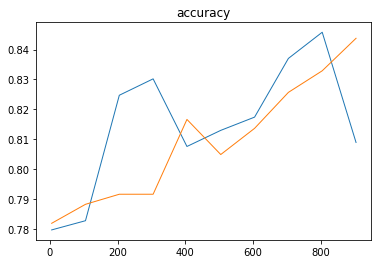

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
bs=100
labeled_count = range(5,(len(perf_hist_multy_acc_avg))*bs,bs)
print(len(labeled_count))
sns.lineplot(x=labeled_count, y=list(perf_hist_multy_acc_avg), sort=False, lw=1).set_title('accuracy')
labeled_count2 = range(5,(len(pref_hist_multy_acc_avg_random))*bs,bs)
print(len(labeled_count))
sns.lineplot(x=labeled_count2, y=pref_hist_multy_acc_avg_random, sort=False, lw=1).set_title('accuracy')

10
10


Text(0.5, 1.0, 'f1')

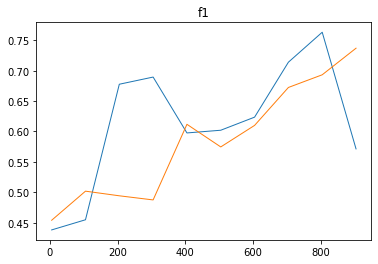

In [ ]:
labeled_count = range(5,len(perf_hist_multy_f1_avg)*bs,bs)
print(len(perf_hist_multy_f1_avg))
sns.lineplot(x=labeled_count, y=list(perf_hist_multy_f1_avg), sort=False, lw=1).set_title('f1')
labeled_count2 = range(5,len(pref_hist_multy_f1_avg_random)*bs,bs)
print(len(pref_hist_multy_f1_avg_random))
sns.lineplot(x=labeled_count2, y=list(pref_hist_multy_f1_avg_random), sort=False, lw=1).set_title('f1')

In [ ]:
pref_hist_multy_random_avg.shape

(20,)

102


Text(0.5, 1.0, 'accuracy')

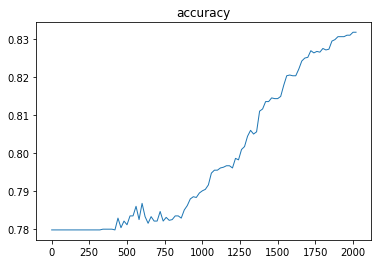

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
labeled_count = range(1,(len(perf_hist_multy_acc_avg))*20,20)
print(len(labeled_count))
sns.lineplot(x=labeled_count, y=perf_hist_multy_acc_avg, sort=False, lw=1).set_title('accuracy')

102


Text(0.5, 1.0, 'f1')

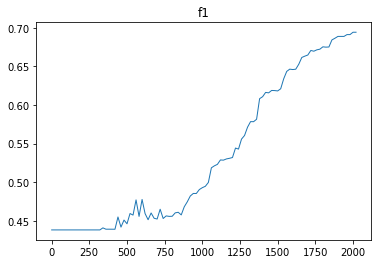

In [ ]:
labeled_count = range(1,len(perf_hist_multy_f1_avg)*20,20)
print(len(perf_hist_multy_f1_avg))
sns.lineplot(x=labeled_count, y=list(perf_hist_multy_f1_avg), sort=False, lw=1).set_title('f1')

In [ ]:
!ls


'6-0-svm-gtweetBert-random-0-0.5-20(train)-10(batch)-acc.np'
'6-0-svm-tweetBert-lc-0-0.5-20(train)-10(batch)-acc.np'
'6-0-svm-tweetBert-lc-0-0.5-20(train)-10(batch)-f1.np'
'6-0-svm-tweetBert-random-0-0.5-20(train)-10(batch)-f1.np'
'7-0-RF-gtweetBert-random-0-0.5-20(train)-100(batch)-acc.np'
'7-0-RF-tweetBert-lc-0-0.5-20(train)-100(batch)-acc.np'
'7-0-RF-tweetBert-lc-0-0.5-20(train)-100(batch)-f1.np'
'7-0-RF-tweetBert-random-0-0.5-20(train)-100(batch)-f1.np'
'8-0-adad-tweetBert-lc-0-0.5-20(train)-100(batch)-acc.np'
'8-0-ada-gtweetBert-random-0-0.5-20(train)-100(batch)-acc.np'
'8-0-ada-tweetBert-lc-0-0.5-20(train)-100(batch)-f1.np'
'8-0-ada-tweetBert-random-0-0.5-20(train)-100(batch)-f1.np'
'8-0-RF-gtweetBert-random-0-0.5-20(train)-50(batch)-acc.np'
'8-0-RF-tweetBert-lc-0-0.5-20(train)-50(batch)-acc.np'
'8-0-RF-tweetBert-lc-0-0.5-20(train)-50(batch)-f1.np'
'8-0-RF-tweetBert-random-0-0.5-20(train)-50(batch)-f1.np'
'9-0-adad-tweetBert-lc-0-0.5-20(train)-100(batch)-acc.np'
'9-0-ada-gtweetBe

In [ ]:
from google.colab import files
files.download('/content/7-0-RF-tweetBert-random-0-0.5-20(train)-100(batch)-f1.np')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>